## Importar bibliotecas

In [ ]:
import numpy as np # linear algebra
from numpy.random import seed 

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, date 

#from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed, Input
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns
from keras.callbacks import EarlyStopping
from IPython.display import display_html # To visualize dataframes side by side
import os
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Para obtener resultados reproducibles

import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
from google.colab  import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Preprocesamiento_variables_meteorologicas/set_de_datos/recorte_26_02_15_07'          
!ls

/content/drive/My Drive/Preprocesamiento_variables_meteorologicas/set_de_datos/recorte_26_02_15_07
division_escalada.jpg  model1		 sol_03_25_07_22.csv
division.jpg	       model.png	 ude_irrad_mar_jul.csv
energy_dataset.csv     sol_02_07_22.csv


## Funciones

Separar el set de datos en secuencias

In [ ]:
def split_sequences(features, targets, n_steps_in, n_steps_out, n_sliding_steps, window_type):
    """
    
    Args:
    * features: Secuencias de entrada que pueden ser univariadas o multvariadas
    * targets: Secuencias de salida que pueden ser univariadas o multvariadas
    * n_steps_in: Longitud de la secuencia de entrada para la ventana deslizante
    * n_steps_out: Longitud de la secuencia de salida.
    * n_sliding_steps: Tamaño del paso de la ventana.
    * window_type: Tipo de ventana 'sliding' or 'expanding'  ('Deslizante o expansiva')
    """
    X, y = list(), list()
    for i in range(0, len(features), n_sliding_steps):

        # Calcula el final de la secuencia en curso
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Comprueba si el ciclo esta fuera del limite de secuencias
        if out_end_ix > len(features):
            break
            
        # Recopila las secuencias de entrada y salida del ciclo
        if window_type == 'sliding': # Sliding window
            seq_x, seq_y = features[i:end_ix, :], targets[end_ix:out_end_ix, :]
        else: # expanding window
            seq_x, seq_y = features[0:end_ix, :], targets[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## Separar el set de datos en secuencias de Entrenamiento, validacion y prueba

In [ ]:
def get_sequences(input_cols, output_cols, input_seq_length, output_seq_length, sliding_steps):
    global index_X_train, index_y_train, index_X_val, index_y_val, index_X_test, index_y_test
    global X_train, y_train, X_val, y_val, X_test, y_test
    global n_features, n_targets
    
    # Calculo de nro. de variables de entrada y salida
    n_features = len(input_cols) - 1 # Número de variables de entrada
    n_targets =  len(output_cols) - 1 # Número de variables de salida

    # Secuencia de muestras para entrenamiento
    X_train, y_train = split_sequences(train_s[input_cols].values,
                                       train_s[output_cols].values,
                                       n_steps_in = input_seq_length,
                                       n_steps_out = output_seq_length,
                                       n_sliding_steps = sliding_steps,
                                       window_type='sliding')

    # Secuencia de muestras para validación
    X_val, y_val = split_sequences(val_s[input_cols].values,
                                   val_s[output_cols].values,
                                   n_steps_in = input_seq_length,
                                   n_steps_out = output_seq_length,
                                   n_sliding_steps = sliding_steps,
                                   window_type='sliding')

    # Secuencia de muestras para evaluación
    X_test, y_test = split_sequences(test_s[input_cols].values,
                                     test_s[output_cols].values,
                                     n_steps_in = input_seq_length,
                                     n_steps_out = output_seq_length,
                                     n_sliding_steps = sliding_steps,
                                     window_type='sliding')

    # Debugging
    print(f"Total de muestras entrenamiento: {X_train.shape[0]}.")
    print(f"Total de muestras validación: {X_val.shape[0]}.")
    print(f"Total de muestras evaluación: {X_test.shape[0]}.")
    
    # Cada muestra contiene los datos de la variable y el indice de tiempo correspondiente.
    # A continuación se almacenan por separado los indices y las variables.
    # Los indices de tiempo servirán para generar las graficas de los datos de predicción.
    
    # Almacenamiento de Indices de tiempo
    index_X_train = X_train[:, :, 0]
    index_y_train = y_train[:, :, 0]
    index_X_val = X_val[:, :, 0]
    index_y_val = y_val[:, :, 0]
    index_X_test = X_test[:, :, 0]
    index_y_test = y_test[:, :, 0]

    # Almacenamiento de las Variables
    X_train = X_train[:, :, -n_features:].astype(np.float32).reshape((X_train.shape[0], input_seq_length, n_features))
    y_train = y_train[:, :, -n_targets:].astype(np.float32)
    X_val = X_val[:, :, -n_features:].astype(np.float32).reshape((X_val.shape[0], input_seq_length, n_features))
    y_val = y_val[:, :, -n_targets:].astype(np.float32)
    X_test = X_test[:, :, -n_features:].astype(np.float32).reshape((X_test.shape[0], input_seq_length, n_features))
    y_test = y_test[:, :, -n_targets:].astype(np.float32)

In [ ]:
from keras import backend
 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [ ]:
## definicion del modelo

def get_model(hidden_size):
    global seq2seq
     
    # Reinicia los estados generados por Keras y TensorFlow para generar una sesión limpia
    tf.keras.backend.clear_session()

    # ----------ENCODER----------
    # Capa de Entrada (Valores historicos).
    encoder_inputs = Input(shape=(input_seq_length, n_features), name='Entrada')
    # Capa de Unidades LSTM.
    encoder_layer = LSTM(hidden_size, return_state=True, name='LSTMencoder')
    # Concatenamiento de la capa de entrada con la capa LSTM.
    encoder_outputs = encoder_layer(encoder_inputs)
    # Almacenamiento del Estado interno (c:cell state) y Estado oculto (h:hidden state) del encoder.
    # encoder_outputs es un vector compuesto por: [hidden state, hidden state, cell state].
    encoder_states = encoder_outputs[1:]

    # ----------DECODER----------
    # Entrada al decoder.
    # Un vector de repetición distribuye la salida de la capa LSTM encoder (h) a todas las unidades LSTM del decoder.
    decoder_inputs = RepeatVector(output_seq_length, name='c')(encoder_outputs[0])
    # Capa de Unidades LSTM.
    # Se concatena con la capa de entrada al decoder, la cual se inicializa con los estados del encoder.
    decoder_layer = LSTM(hidden_size, return_sequences=True, name='LSTMdecoder')(decoder_inputs, initial_state=encoder_states)
    # Capa de Salida.
    # Se predice la secuencia de salida con una capa densa encapsulada en una función de distribución temporal.
    decoder_outputs = TimeDistributed(Dense(n_targets), name='Salida')(decoder_layer)

    # Creación de Modelo
    seq2seq = Model(encoder_inputs, decoder_outputs)

    # Compilador
    seq2seq.compile(optimizer='adam', # Optimizador 
                  loss='mse', # Función de perdida
                  metrics=[rmse])


In [ ]:
def train_model(epochs, batch_size, min_delta, patience, verbose):
    global history, monitor
    
    monitor = EarlyStopping(monitor='val_loss', # Metrica a monitorear.
                            min_delta = min_delta, # Cambio minimo considerado como mejora
                            patience = patience, # Número de épocas sin mejora tras las cuales se detendrá el entrenamiento.
                            verbose = 1, # Debugging
                            restore_best_weights = True, # Restablece los pesos de la época con el mejor valor de 'val_loss'.
                            mode = 'auto')

    history = seq2seq.fit(X_train, y_train, # Set de Entrenamiento
                          validation_data=(X_val, y_val), # Set de Validación
                          epochs = epochs, # Número de epocas
                          callbacks = [monitor], # Early Stopping
                          batch_size = batch_size, # Número de muestras en cada batch
                          verbose = verbose, # Debugging
                          shuffle = False # Mantener la secuencia de los datos
                         )

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]

    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    fig, (ax,ax1) = plt.subplots(1,2,figsize=(15,8))
    fig.patch.set_facecolor('white')

    for l in loss_list:
        ax.plot(epochs, history.history[l], color = 'cornflowerblue', label='Training loss')
    for l in val_loss_list:
        ax.plot(epochs, history.history[l], color =  'orange', label='Validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc=1)

    ## RMSE
    ax1.plot(np.array(epochs), np.array(history.history['rmse']), color = 'cornflowerblue', label='Training RMSE')
    ax1.plot(np.array(epochs), np.array(history.history['val_rmse']), color = 'orange', label='Validation RMSE')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')
    ax1.legend(loc=1)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show;



In [ ]:
def test_model():
    global y_pred
    
    # Predicción utilizando los datos de test
    y_pred = seq2seq.predict(X_test, verbose=0)
    
    # Reescalado de la variable
    rescale_var()
    
        
    # Evaluación del modelo
    test_rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1)))
    print('Evaluation metric results:')
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f'MSE is : {mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))}')
    print(f'MAE 1s: {mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))}')
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f'MAPE 1s: {mean_absolute_percentage_error(y_test.reshape(-1), y_pred.reshape(-1))}') 
    print(f'R2 is : {r2_score(y_test.reshape(-1), y_pred.reshape(-1))}',end = '\n\n')

    return test_rmse

In [ ]:
def rescale_var():
    global X_test, y_test, y_pred
    
    scaler2 = StandardScaler()
    scaler2.scale_, scaler2.mean_, scaler2.var_ = scaler.scale_[0], scaler.mean_[0], scaler.var_[0]
    X_test_s1, X_test_s2, X_test_s3 = X_test.shape[0],X_test.shape[1],X_test.shape[2]
    y_test_s1, y_test_s2, y_test_s3 = X_test.shape[0],y_test.shape[1],y_test.shape[2]
    y_pred_s1, y_pred_s2, y_pred_s3 = y_pred.shape[0],y_pred.shape[1],y_pred.shape[2]
    
    X_test = scaler2.inverse_transform(X_test.reshape(X_test.shape[0],X_test.shape[1])).reshape(X_test_s1, X_test_s2, X_test_s3)
    y_test = scaler2.inverse_transform(y_test.reshape(y_test.shape[0],y_test.shape[1])).reshape(y_test_s1, y_test_s2, y_test_s3)
    y_pred = scaler2.inverse_transform(y_pred.reshape(y_pred.shape[0],y_pred.shape[1])).reshape(y_pred_s1, y_pred_s2, y_pred_s3)

    

In [ ]:
def plot_var(sample, freq, width, height):
    fig, ax=plt.subplots(1,1,figsize=(width, height))
    fig.patch.set_facecolor('white')


    ax.set_ylabel('Radiación [$W/m^2$]')

        
    if n_features > 1: # Grafica para entrada multivariable
        sns.lineplot(x=index_X_test[sample, 1728:], y=X_test[sample, 1728:, 0].reshape(-1), ax=ax, color='b', label='Valores Vistos (Pasado)', linestyle='-', marker=',')
        sns.lineplot(x=index_y_test[sample, 1728:], y=y_test[sample,1728:, 0], ax=ax, color='b', label='Valores Futuros Verdaderos', linestyle='--')
        sns.lineplot(x=index_y_test[sample, 1728:], y=y_pred[sample, 1728:, 0], ax=ax, color='r', label='Predicciones', linestyle='--', marker='o')
    else: # Grafica para entrada univariada
        sns.lineplot(x=index_X_test[sample], y=X_test[sample,:, 0].reshape(-1), ax=ax, color='b', label='Valores Vistos (Pasado)', linestyle='-', marker=',')
        sns.lineplot(x=index_y_test[sample], y=y_test[sample,:, 0].reshape(-1), ax=ax, color='b', label='Valores Futuros Verdaderos', linestyle='--')
        sns.lineplot(x=index_y_test[sample], y=y_pred[sample,:, 0].reshape(-1), ax=ax, color='r', label='Predicciones', linestyle='--', marker='*')

    idx = pd.date_range(start=index_X_test[sample][0], end=index_y_test[sample][-1], freq=freq)
    ax.set_xticks(idx)
    myFmt = mdates.DateFormatter('%d/%m/%y, %I%p')
    ax.xaxis.set_major_formatter(myFmt)
    plt.xticks(rotation=10)

    plt.legend(loc=2)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    # plt.savefig('division.jpg', dpi=300, bbox_inches='tight')
    plt.show;

## Lectura de datos

In [ ]:
df = pd.read_csv('sol_02_07_22.csv', usecols=['date_sol', 'Ghi'], index_col='date_sol', parse_dates=['date_sol'])
df.sample(5)

,Ghi
date_sol,
2022-06-12 08:15:00,295
2022-06-06 04:40:00,0
2022-06-15 13:55:00,584
2022-02-27 22:35:00,0
2022-06-02 06:10:00,15


## Separacion del set de datos en entrenamiento, validacion y prueba

In [ ]:
train = df.iloc[:24020]
val = df.iloc[24020:32027]
test = df.iloc[32027:]

In [ ]:
print(' Dimensiones datos de entrenamineto: ' + str(train.shape))
print(' Dimensiones datos de valiacion: ' + str(val.shape))
print(' Dimensiones datos de prueba: ' + str(test.shape))

 Dimensiones datos de entrenamineto: (24020, 1)
 Dimensiones datos de valiacion: (8007, 1)
 Dimensiones datos de prueba: (8006, 1)


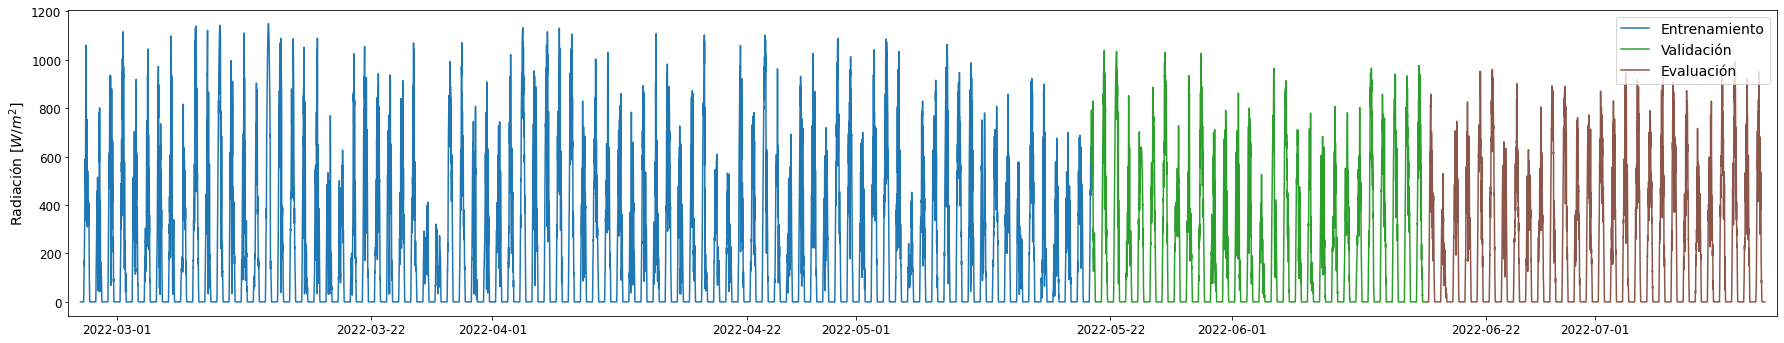

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(25,5))
fig.patch.set_facecolor('white')
ax.plot(df.iloc[:24020], label='Entrenamiento', c='tab:blue', linewidth='1.5')
ax.plot(df.iloc[24020:32027], label='Validación', c='tab:green', linewidth='1.5')
ax.plot(df.iloc[32027:], label='Evaluación', c='tab:brown', linewidth='1.5')
ax.set_ylabel('Radiación [$W/m^2$]')
ax.set_xlim(pd.to_datetime('2022-02-25'),pd.to_datetime('2022-07-16'))
plt.legend(loc=1)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('division.jpg', dpi=300, bbox_inches='tight')
plt.show;

## Estandarizacion de datos

In [ ]:
train.shape

(24020, 1)

In [ ]:
train_val = df.iloc[:32027]
scaler = StandardScaler()
scaler.fit_transform(train_val);

In [ ]:
train_scal = scaler.transform(train)
val_scal = scaler.transform(val)
test_scal = scaler.transform(test)

In [ ]:
serie = np.concatenate((train_scal, val_scal, test_scal), axis=0)
dfs = pd.DataFrame(serie)
dfs = pd.concat([df.reset_index()['date_sol'], dfs], axis=1)
dfs.rename({'date_sol':'Fecha', 0:'Ghi'}, axis=1, inplace=True)
dfs.set_index('Fecha', inplace=True)

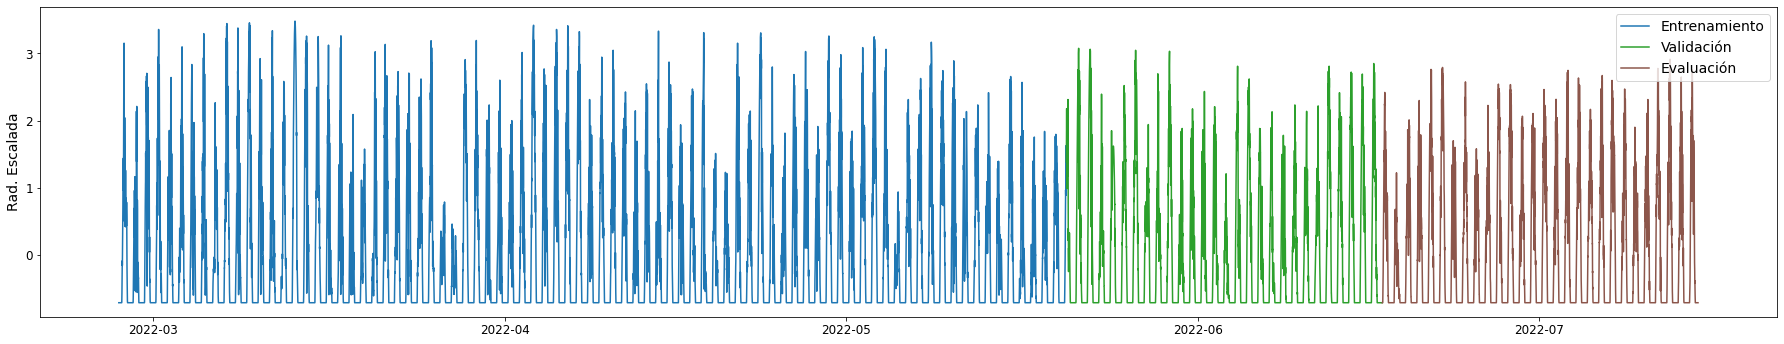

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(25,5))
fig.patch.set_facecolor('white')
ax.plot(dfs.iloc[:24020], label='Entrenamiento', c='tab:blue', linewidth='1.5')
ax.plot(dfs.iloc[24020:32027], label='Validación', c='tab:green', linewidth='1.5')
ax.plot(dfs.iloc[32027:], label='Evaluación', c='tab:brown', linewidth='1.5')
ax.set_ylabel('Rad. Escalada')
# ax.set_xlim(pd.to_datetime('2007'),pd.to_datetime('2021'))
plt.legend(loc=1)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('division_escalada.jpg', dpi=300, bbox_inches='tight')
plt.show;

In [ ]:
# Entrenamiento
train_s = dfs.iloc[:24020]
train_s.reset_index(inplace=True)
# Validación
val_s = dfs.iloc[24020:32027]
val_s.reset_index(inplace=True)
# Evaluación
test_s = dfs.iloc[32027:]
test_s.reset_index(inplace=True)

* input_seq_length = 2304 # Pasado Historico. Input [5min]
* output_seq_length = 12 # Futuro de Predicción. Output [5min]
* sliding_steps = 12 # Pasos que recorre la ventana deslizante en la serie de 

 * 1 Hora = 12 muestras
 * 3 Horas = 36 muestras
 * 6 horas = 60 pasos de tiempo
 * 9 Horas  = 108 pasos de tiempo
 * 12 horas = 144 pasos de tiempo
 * 24 Horas  = 288 pasos de tiempo

In [ ]:
input_cols = ['Fecha', 'Ghi'] # Variables de Entrada
output_cols = ['Fecha', 'Ghi'] # Variables a predecir
input_seq_length = 2304 # Pasado Historico. Input [5min]
output_seq_length = 144 # Futuro de Predicción. Output [5min]
sliding_steps = 12 # Pasos que recorre la ventana deslizante en la serie de tiempo [5min]

get_sequences(input_cols, output_cols, input_seq_length, output_seq_length, sliding_steps)

Total de muestras entrenamiento: 1798.
Total de muestras validación: 464.
Total de muestras evaluación: 464.


## Creacion del modelo

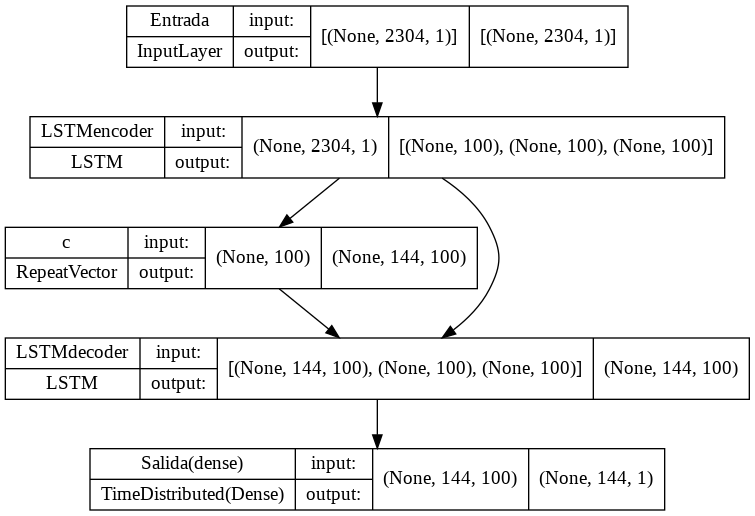

In [ ]:
hidden_size = 100 # Número de unidades LSTM
get_model(hidden_size)
plot_model(seq2seq, show_shapes=True, show_layer_names=True)

Epoch 1/100
7/7 [==============================] - 10s 316ms/step - loss: 0.9994 - rmse: 0.8173 - val_loss: 0.7824 - val_rmse: 0.7370
Epoch 2/100
7/7 [==============================] - 1s 189ms/step - loss: 0.8453 - rmse: 0.7126 - val_loss: 0.8845 - val_rmse: 0.7179
Epoch 3/100
7/7 [==============================] - 1s 191ms/step - loss: 0.8336 - rmse: 0.6780 - val_loss: 0.5975 - val_rmse: 0.5745
Epoch 4/100
7/7 [==============================] - 1s 194ms/step - loss: 0.7454 - rmse: 0.6327 - val_loss: 0.5928 - val_rmse: 0.5966
Epoch 5/100
7/7 [==============================] - 1s 195ms/step - loss: 0.7092 - rmse: 0.6076 - val_loss: 0.5648 - val_rmse: 0.5407
Epoch 6/100
7/7 [==============================] - 1s 193ms/step - loss: 0.6808 - rmse: 0.5910 - val_loss: 0.5452 - val_rmse: 0.5534
Epoch 7/100
7/7 [==============================] - 1s 195ms/step - loss: 0.6580 - rmse: 0.5859 - val_loss: 0.5281 - val_rmse: 0.5041
Epoch 8/100
7/7 [==============================] - 1s 195ms/step - l

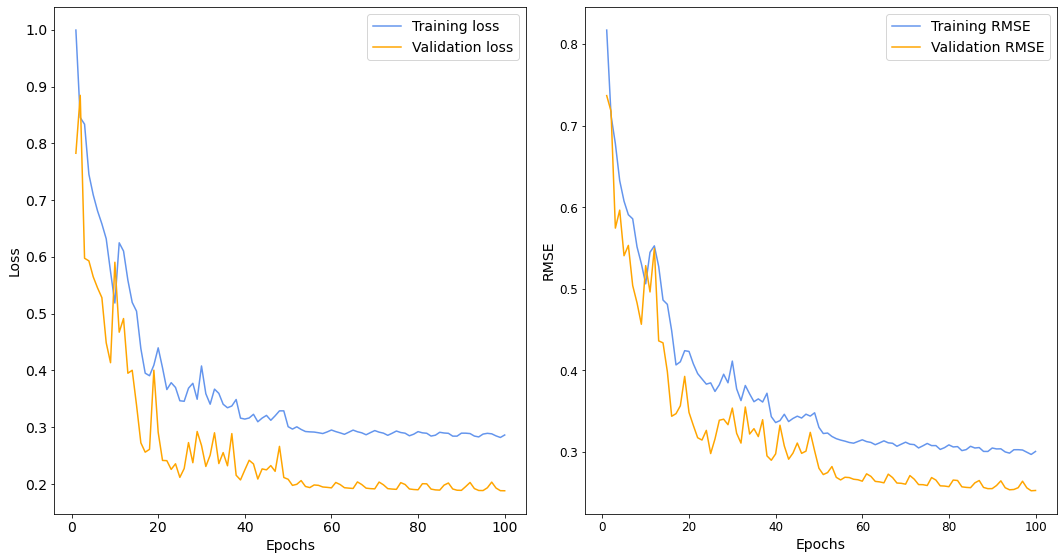

In [ ]:
# Ajustes de entrenamiento
epochs = 100 # Número de epocas
batch_size = 288 # Número de muestras en cada batch
verbose = 1 # Debugging

# Ajustes de Early Stopping
min_delta = 0.0001 # Cambio minimo considerado como mejora
patience = 15 # Número de épocas sin mejora tras las cuales se detendrá el entrenamiento.

train_model(epochs, batch_size, min_delta, patience, verbose)
plot_history(history)

In [ ]:
test_rmse = test_model()

Evaluation metric results:
Testing RMSE: 101.1845
MSE is : 10238.296875
MAE 1s: 57.18253707885742
Testing RMSE: 101.1845
MAPE 1s: 232620.75
R2 is : 0.8579656087604808



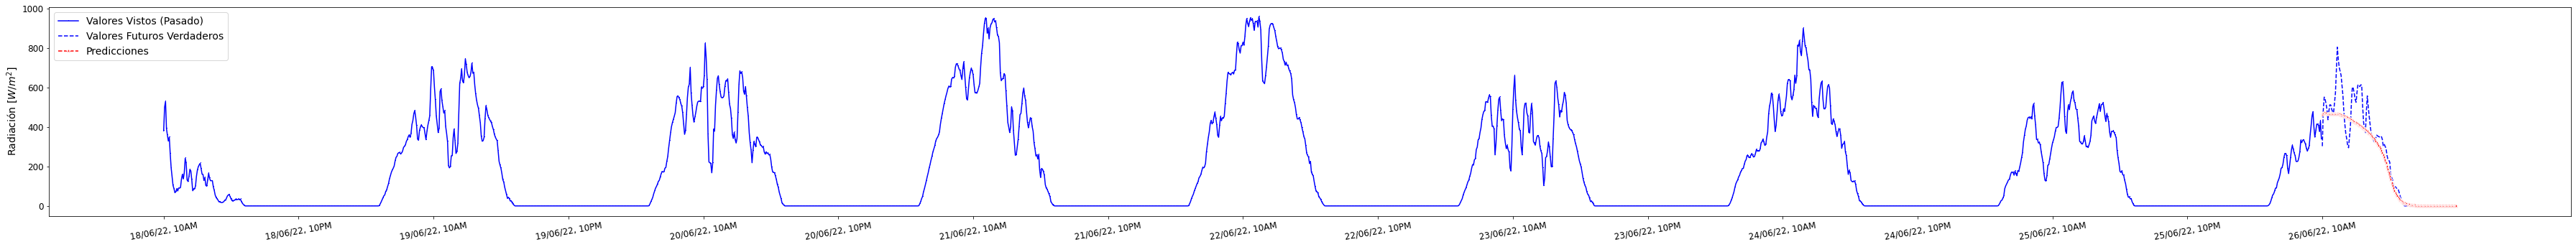

In [ ]:
sample = 30 # Indice de Muestra a graficar
freq = '12h' # Frecuencia de divisiones en el eje de tiempo
width = 50 # Ancho de grafica
height = 5 # Alto de grafica

plot_var(sample, freq, width, height)

In [ ]:
df_p = pd.DataFrame(index_y_test.reshape(-1),columns=['Fecha'])
df_p['Ghi'] = y_test.reshape(-1)  
df_p['Ghi_p'] = y_pred.reshape(-1) 
df_p['Fecha'].duplicated().sum()
df_p = df_p.drop_duplicates('Fecha', keep = 'last')
df_p = df_p.groupby('Fecha').sum() 

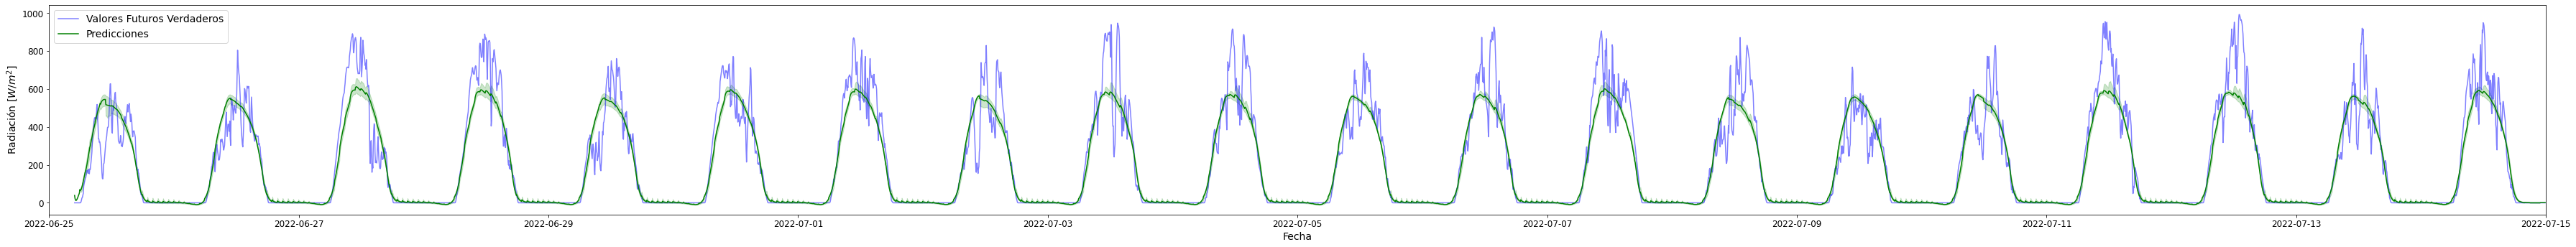

In [ ]:

fig, ax=plt.subplots(1,1,figsize=(width, height))
fig.patch.set_facecolor('white')


ax.set_ylabel('Radiación [$W/m^2$]')


sns.lineplot(data = df_p , x=df_p.index, y=df_p['Ghi'], ax=ax, color='b', label='Valores Futuros Verdaderos', alpha = 0.5)
# sns.lineplot(data = df_p , x=df_p.index, y=df_p['Ghi_p'], ax=ax, color='g', label='Predicciones', linestyle='-')
sns.lineplot(x=pd.to_datetime(index_y_test.reshape(-1)), y=y_pred.reshape(-1), ax=ax, color='g', label='Predicciones', linestyle='-')

ax.set_xlim([date(2022, 6, 25), date(2022, 7, 15)])


plt.legend(loc=2)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('division.jpg', dpi=300, bbox_inches='tight')
plt.show();